In [ ]:
import random, gymnasium, torch, os, glob, subprocess
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio.v3 as imageio
from IPython.display import display, clear_output, Image
from render.CollectFrames import collect_saved_frames
matplotlib.use('Agg')

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


#### The specific neural network for the pole balancing problem

In [19]:
class QNetwork(torch.nn.Module):
    def __init__(self, num_obs: int, num_act: int):
        super().__init__()
        self.layer1 = torch.nn.Linear(num_obs, 64)
        self.layer2 = torch.nn.Linear(64, 192)
        self.layer3 = torch.nn.Linear(192, 128)
        self.layer4 = torch.nn.Linear(128, 64)
        self.layer5 = torch.nn.Linear(64, num_act)
    
    def forward(self, x):
        x = x.to(DEVICE)
        x = torch.nn.functional.leaky_relu(self.layer1(x))
        x = torch.nn.functional.leaky_relu(self.layer2(x))
        x = torch.nn.functional.leaky_relu(self.layer3(x))
        x = torch.nn.functional.leaky_relu(self.layer4(x))
        return self.layer5(x)

#### Class to train the neural network using Q-learning supervisor

In [20]:
class QTrainingSession:
    def __init__(self, end_score=500.0, lrn_rate=0.001):
        self.env = gymnasium.make("CartPole-v1", render_mode="rgb_array")
        self.num_actions = self.env.action_space.n
        self.num_obs = len(self.env.reset()[0])
        self.network = QNetwork(self.num_obs, self.num_actions).to(DEVICE)
        self.optimizer = torch.optim.AdamW(self.network.parameters(), lr=lrn_rate, amsgrad=True)
        self.loss_function = torch.nn.MSELoss()
        self.end_score = end_score

    def _select_action(self, predicted_values: torch.Tensor, eps_threshold: float):
        if random.random() >= eps_threshold:
            return predicted_values.max(1).indices.item()
        else:
            return self.env.action_space.sample()

    def _make_state(self, obs: tuple):
        return torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)

    def train(
            self, 
            num_episodes = 1000,
            episode_render_mod = 10,
            num_perfect_to_end = 5,
            discount_factor = 0.99,
            eps = 0.1):
        queue = [0] * num_perfect_to_end
        for episode in range(num_episodes):
            current_state = self._make_state(self.env.reset()[0])
            total_reward, done = 0, False
            yield self.env.render(), episode, total_reward
            while not done:
                # Predict Q-values for current state
                predicted_values = self.network(current_state)
                # Choose action (Epsilon-Static approach)
                action_idx = self._select_action(predicted_values, eps)
                # Execute action in the environment and observe result
                next_obs, reward, terminated, truncated, _ = self.env.step(action_idx)
                total_reward += reward
                gen_frame = episode % episode_render_mod == 0
                frame = self.env.render() if gen_frame else None
                yield frame, episode, total_reward
                done = terminated or truncated
                next_state = None if done else self._make_state(next_obs)
                # Get max Q-value for the next state
                max_qvalue_next = 0.0
                if not done and next_state is not None:
                    with torch.no_grad():
                        max_qvalue_next = self.network(next_state).max(1).values.item()
                # Calculate the final target qvalue using the Bellman equation
                qvalue = reward + (discount_factor * max_qvalue_next)
                # Construct the target vector for backpropagation
                target_qvalue_vector = predicted_values.clone().detach()
                target_qvalue_vector[0, action_idx] = qvalue
                # Calculate loss and backpropagate it
                loss = self.loss_function(predicted_values, target_qvalue_vector)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                # Update the current state to the next one
                current_state = next_state
            queue = queue[1:] + [total_reward]
            if sum(queue) / num_perfect_to_end >= self.end_score:
                break

    def predict(self, num_predictions=10, prediction_render_mod=1):
        for prediction in range(num_predictions):
            current_state = self._make_state(self.env.reset()[0])
            total_reward, done = 0, False
            yield self.env.render(), prediction, total_reward
            while not done:
                # Predict Q-values for current state
                with torch.no_grad():
                    predicted_values = self.network(current_state)
                # Choose action (Epsilon-Static approach)
                action_idx = self._select_action(predicted_values, 0.0)
                # Execute action in the environment and observe result
                next_obs, reward, terminated, truncated, _ = self.env.step(action_idx)
                total_reward += reward
                gen_frame = prediction % prediction_render_mod == 0
                frame = self.env.render() if gen_frame else None
                yield frame, prediction, total_reward
                done = terminated or truncated
                next_state = None if done else self._make_state(next_obs)
                # Update the current state to the next one
                current_state = next_state

#### Function to put metadata text into the gymnasium environment frame

In [21]:
def add_text_to_frame(array: np.ndarray, title: str, episode: int, reward: int, dpi=75):
    height, width, _ = array.shape
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi, frameon=False)
    axes = fig.add_axes([0, 0, 1, 1])
    axes.axis('off')
    axes.imshow(array, aspect='auto', interpolation='nearest')
    text = f"{title}: {episode}\nReward: {reward:.0f}"
    axes.text(0.05, 0.95, text, color='black', fontsize=13, ha='left', va='top', transform=axes.transAxes)
    fig.canvas.draw()
    frame_with_text = np.array(fig.canvas.buffer_rgba())[:, :, :3]
    plt.close(fig)
    return frame_with_text

#### Train the neural network using Q-learning supervisor and collect frames

In [ ]:
folder_path = "gifs/balancing/"
os.makedirs(folder_path, exist_ok=True)

In [24]:
session = QTrainingSession(end_score=400)
frames_chunk = 25
num_episodes = 1000
episode_rewards = []

In [25]:
prev_episode, prev_reward = 0, 0
for idx, (frame, episode, total_reward) in enumerate(session.train(num_episodes, frames_chunk, 20)):        
    if episode != prev_episode:
        print(f"Episode: {episode - 1} ({prev_reward:.0f})")
        episode_rewards.append(prev_reward)
        prev_episode = episode
    prev_reward = total_reward
    if episode % frames_chunk == 0:
        frame_with_text = add_text_to_frame(frame, "Episode", episode, total_reward)
        imageio.imwrite(os.path.join(folder_path, f"PoleBalancingTrain{idx:08d}.png"), frame_with_text)
print(f"Episode: {episode} ({prev_reward})")
episode_rewards.append(prev_reward)
clear_output()
print(f"Number of trained episodes: {episode}")

Number of trained episodes: 515


In [26]:
train_gif_filename = "PoleBalancingTrain.gif"
collect_saved_frames(folder_path, train_gif_filename)

#### Visualize the learning process

![Pole Balancing Train](gifs/balancing/PoleBalancingTrain.gif)

#### Visualize the rewards over time

In [28]:
rewards_chunk = 10
averaged_rewards = [
    sum(episode_rewards[i * rewards_chunk : i * rewards_chunk + rewards_chunk]) / rewards_chunk 
    for i in range(len(episode_rewards) // rewards_chunk)
]

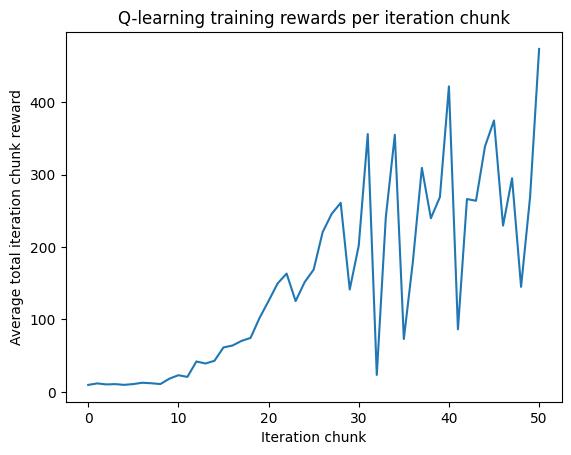

In [29]:
%matplotlib inline
plt.plot(averaged_rewards)
plt.xlabel('Iteration chunk')
plt.ylabel('Average total iteration chunk reward')
plt.title('Q-learning training rewards per iteration chunk')
plt.show()

#### Test the neural network and collect frames

In [35]:
test_rewards = []
prev_test, prev_reward = 0, 0
for idx, (frame, prediction, total_reward) in enumerate(session.predict(num_predictions=5)):
    if prediction != prev_test:
        print(f"Prediction: {prediction - 1} ({prev_reward:.0f})")
        test_rewards.append(prev_reward)
        prev_test = prediction
    prev_reward = total_reward
    frame_with_text = add_text_to_frame(frame, "Test", prediction, total_reward)
    imageio.imwrite(os.path.join(folder_path, f"PoleBalancingTest{idx:08d}.png"), frame_with_text)
print(f"Prediction: {prediction} ({prev_reward})")
test_rewards.append(prev_reward)
clear_output()

In [36]:
test_gif_filename = "PoleBalancingTest.gif"
collect_saved_frames(folder_path, test_gif_filename)

#### Visualize the tests

![Pole Balancing Test](gifs/balancing/PoleBalancingTest.gif)

#### Visualize the test results fluctuation

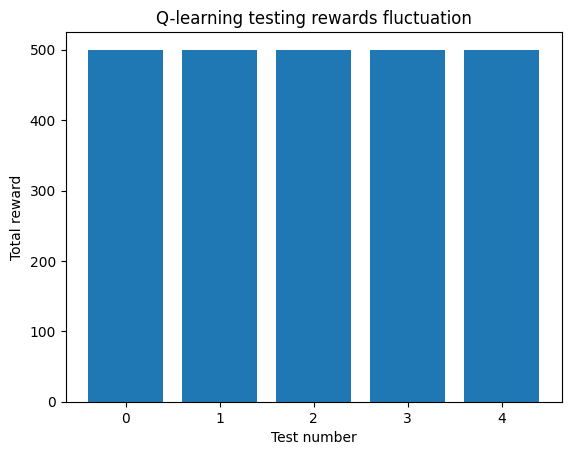

In [38]:
%matplotlib inline
x_positions = range(len(test_rewards))
plt.bar(x_positions, test_rewards)
plt.xlabel('Test number')
plt.ylabel('Total reward')
plt.title('Q-learning testing rewards fluctuation')
plt.xticks(x_positions)
plt.show()